# PREDICCIÓN DE VENTAS SEMANALES DE WALMART

### Modelo de regresión con Pycaret y Sklearn

#### Etapas del modelo
1. Análisis de calidad de datos
2. Análisis exploratorio de datos (EDA)
3. Ingenieria de caracteristicas (creación de columnas, categorias, eliminar, limpiezas,transformaciones, etc)
4. Fase de modelado:
- Pycaret
- Sklearn
5. Comparación de modelos con métricas
6. Resultados y conclusiones


## Fase 1:
### Instalación de librerías y carga de datos desde MySQL

In [1]:
#pip install mysql

In [2]:
#pip install mysql-connector-python

In [3]:
#pip install pandas

In [4]:
#pip install numpy
 

In [5]:
#pip install seaborn 

In [6]:
#pip install scikit-learn

In [7]:
# Importación de librerías

## Manipulación de datos
import pandas as pd
import numpy as np

# Visualización de datos
import seaborn as sns
import matplotlib.pyplot as plt

# Modelado y evaluación
import sklearn 

In [8]:

# Procesamiento y modelado con skylearn
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

## Modelos robustos de regresión
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.svm import SVR

from xgboost import XGBRegressor

from lightgbm import LGBMRegressor

pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:.2f}'.format)

In [9]:
# Conectar base de datos con MySQL
import mysql.connector
from mysql.connector import Error

Conexion = mysql.connector.connect(
    host='localhost',       
    database='curso_python',
    user='root',
    password='Maracuya134',
    port='3306'
)

    

In [10]:
Query = "SELECT * FROM curso_python.walmart;"

In [11]:
df_walmart = pd.read_sql(Query, Conexion)

C:\Users\rrosm\AppData\Local\Temp\ipykernel_21088\156267084.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_walmart = pd.read_sql(Query, Conexion)


In [12]:
# Analisis exploratorio de datos
df_walmart.head()
df_walmart.info()
df_walmart.describe()
df_walmart.isnull().sum()
df_walmart.duplicated().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6435 entries, 0 to 6434
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Store         6435 non-null   int64  
 1   Date          6435 non-null   object 
 2   Weekly_Sales  6435 non-null   float64
 3   Holiday_Flag  6435 non-null   int64  
 4   Temperature   6435 non-null   float64
 5   Fuel_Price    6435 non-null   float64
 6   CPI           6435 non-null   float64
 7   Unemployment  6435 non-null   float64
dtypes: float64(5), int64(2), object(1)
memory usage: 402.3+ KB


np.int64(0)

In [13]:
df_walmart.head()

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,1,05-02-2010,1643690.90,0,42.31,2.57,211.10,8.11
1,1,12-02-2010,1641957.44,1,38.51,2.55,211.24,8.11
2,1,19-02-2010,1611968.17,0,39.93,2.51,211.29,8.11
3,1,26-02-2010,1409727.59,0,46.63,2.56,211.32,8.11
4,1,05-03-2010,1554806.68,0,46.50,2.62,211.35,8.11


In [14]:
df_walmart.shape

(6435, 8)

### Analisis de calidad de datos

In [15]:
# Verificación de valores nulos
nulos = df_walmart.isnull().sum()
nulos

Store           0
Date            0
Weekly_Sales    0
Holiday_Flag    0
Temperature     0
Fuel_Price      0
CPI             0
Unemployment    0
dtype: int64

In [16]:
# Verificación de duplicados
duplicados = df_walmart.duplicated().sum()
duplicados

np.int64(0)

In [17]:
# Conversión de la columna 'Date' a tipo datetime
df_walmart['Date'] = pd.to_datetime(df_walmart['Date'], format='%d-%m-%Y')

# Identificar fecha minima y máxima
fecha_min = df_walmart['Date'].min()
fecha_max = df_walmart['Date'].max()

print(f"Fecha mínima: {fecha_min}")
print(f"Fecha máxima: {fecha_max}")

Fecha mínima: 2010-02-05 00:00:00
Fecha máxima: 2012-10-26 00:00:00


In [18]:
# Estadísticas basicas
df_walmart.describe()

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
count,6435.00,6435,6435.00,6435.00,6435.00,6435.00,6435.00,6435.00
mean,23.00,2011-06-17 00:00:00,1046964.88,0.07,60.66,3.36,171.58,8.00
min,1.00,2010-02-05 00:00:00,209986.25,0.00,-2.06,2.47,126.06,3.88
25%,12.00,2010-10-08 00:00:00,553350.10,0.00,47.46,2.93,131.74,6.89
50%,23.00,2011-06-17 00:00:00,960746.04,0.00,62.67,3.44,182.62,7.87
75%,34.00,2012-02-24 00:00:00,1420158.66,0.00,74.94,3.73,212.74,8.62
max,45.00,2012-10-26 00:00:00,3818686.45,1.00,100.14,4.47,227.23,14.31
std,12.99,NaN,564366.62,0.26,18.44,0.46,39.36,1.88


In [19]:
df_walmart.head()

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,1,2010-02-05,1643690.90,0,42.31,2.57,211.10,8.11
1,1,2010-02-12,1641957.44,1,38.51,2.55,211.24,8.11
2,1,2010-02-19,1611968.17,0,39.93,2.51,211.29,8.11
3,1,2010-02-26,1409727.59,0,46.63,2.56,211.32,8.11
4,1,2010-03-05,1554806.68,0,46.50,2.62,211.35,8.11


### Análisis exploratorio de datos (EDA)

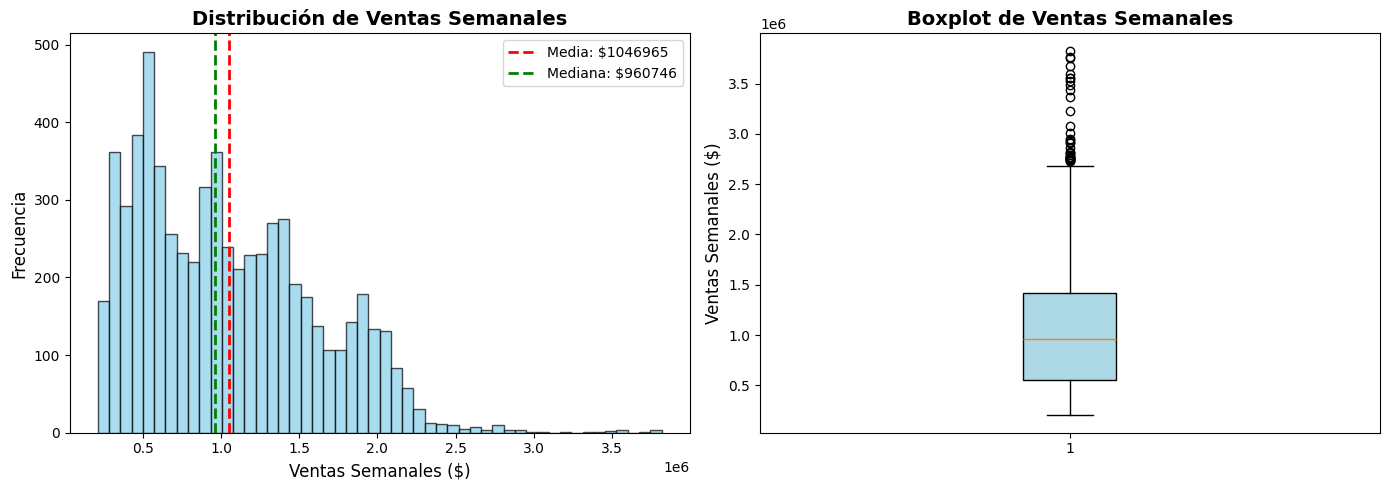


 Resumen Estadístico de Weekly_Sales:
 Media: $1046964.88
 Mediana: $960746.04
 Desv. Estándar: $564366.62
 Mínimo: $209986.25
 Máximo: $3818686.45


In [20]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histograma de la variable 'Weekly_Sales'
axes[0].hist(df_walmart['Weekly_Sales'], bins=50, color='skyblue', edgecolor='black', alpha=0.7)
axes[0].axvline(df_walmart['Weekly_Sales'].mean(), color='red', linestyle='--', linewidth=2, label=f'Media: ${df_walmart["Weekly_Sales"].mean():.0f}')
axes[0].axvline(df_walmart['Weekly_Sales'].median(), color='green', linestyle='--', linewidth=2, label=f'Mediana: ${df_walmart["Weekly_Sales"].median():.0f}')
axes[0].set_xlabel('Ventas Semanales ($)', fontsize=12)
axes[0].set_ylabel('Frecuencia', fontsize=12)
axes[0].set_title('Distribución de Ventas Semanales', fontsize=14, fontweight='bold')
axes[0].legend()

# Boxplot de la variable 'Weekly_Sales'
box = axes[1].boxplot(df_walmart['Weekly_Sales'], vert=True, patch_artist=True)
box['boxes'][0].set(facecolor='lightblue')
axes[1].set_ylabel('Ventas Semanales ($)', fontsize=12)
axes[1].set_title('Boxplot de Ventas Semanales', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig('01_distribucion_ventas_semanales.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n Resumen Estadístico de Weekly_Sales:")
print(f" Media: ${df_walmart['Weekly_Sales'].mean():.2f}")
print(f" Mediana: ${df_walmart['Weekly_Sales'].median():.2f}")
print(f" Desv. Estándar: ${df_walmart['Weekly_Sales'].std():.2f}")
print(f" Mínimo: ${df_walmart['Weekly_Sales'].min():.2f}")
print(f" Máximo: ${df_walmart['Weekly_Sales'].max():.2f}")

In [21]:
from scipy import stats
asimetria = stats.skew(df_walmart['Weekly_Sales'])
curtosis = stats.kurtosis(df_walmart['Weekly_Sales'])

print(f"\n Asimetría de Weekly_Sales: {asimetria:.2f}")
print(f" Curtosis de Weekly_Sales: {curtosis:.2f}")


 Asimetría de Weekly_Sales: 0.67
 Curtosis de Weekly_Sales: 0.05


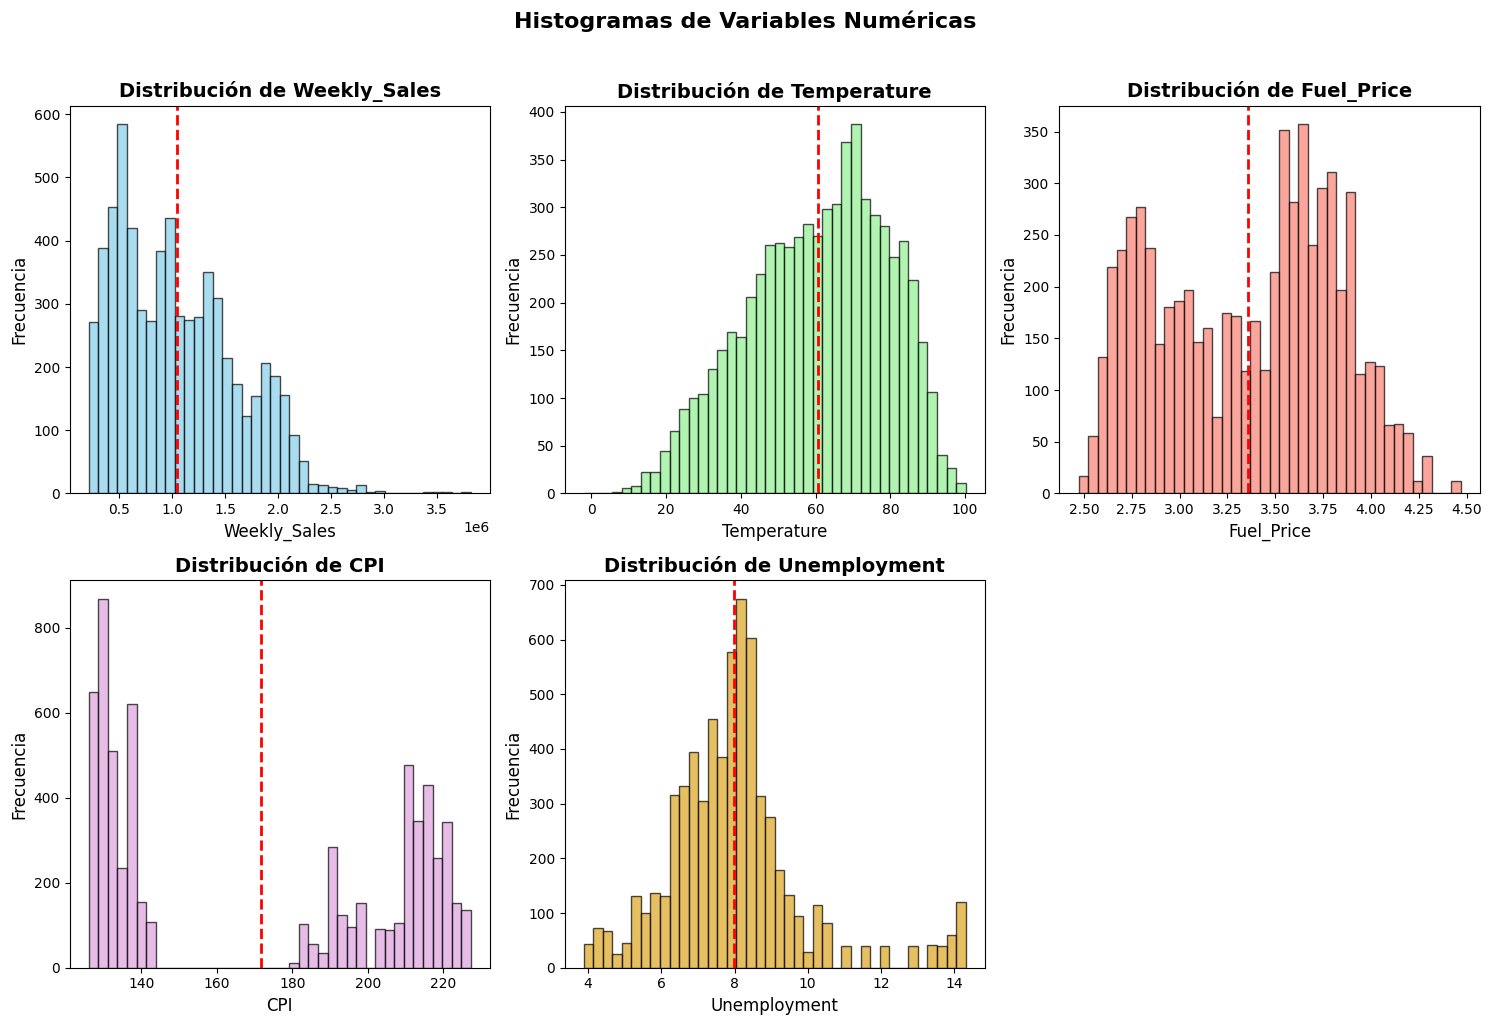

In [22]:
# Seleccionar las variables numéricas (Incluyendo Store y Holiday_Flag)
numeric_vars = ['Weekly_Sales', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment']

fig, ax = plt.subplots(2, 3, figsize=(15, 10))
axes = ax.flatten()

colors = ['skyblue', 'lightgreen', 'salmon', 'plum', 'goldenrod']

for i, var in enumerate(numeric_vars):
    axes[i].hist(df_walmart[var], bins=40, color=colors[i], edgecolor='black', alpha=0.7)
    axes[i].axvline(df_walmart[var].mean(), color='red', linestyle='--', linewidth=2)
    axes[i].set_xlabel(var, fontsize=12)
    axes[i].set_ylabel('Frecuencia', fontsize=12)
    axes[i].set_title(f'Distribución de {var}', fontsize=14, fontweight='bold')

# Ocultar el subplot vacío
axes[5].axis('off')

plt.suptitle('Histogramas de Variables Numéricas', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('02_histogramas_variables_numericas.png', dpi=150, bbox_inches='tight')
plt.show()

###### Conclusiones gráficas: La distribución de temperatura es medianamente uniforme, hay algunos valores muy extremos y la simetría es hacía la izquierda. La distribución del precio es dispersa, no se ve una distribución uniforme, se concentran valores fuertes, lo mismo pasa con el CPI, en la distribución de desempleo la distibución es anormal, la distribucuión de Weekly Sales, tiene una distribución con una cola hacía la derecha, con simetria hacía la derecha. 

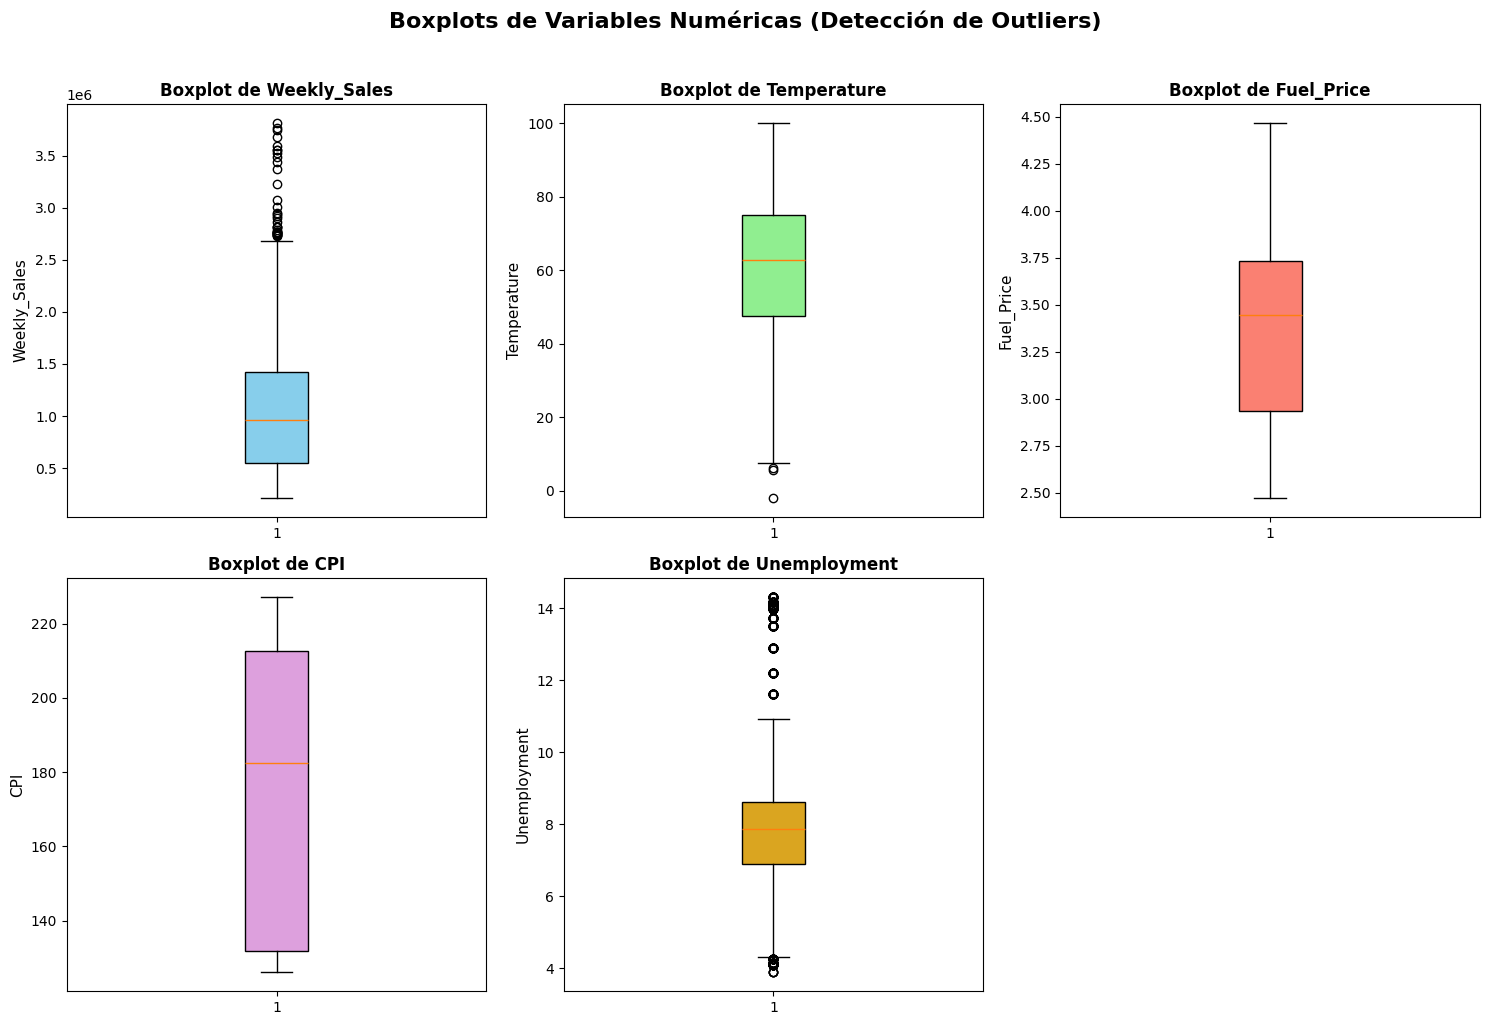

In [23]:
fig, axes = plt.subplots(2, 3, figsize=(15,10))
axes = axes.flatten()

for i, var in enumerate(numeric_vars):
    box = axes[i].boxplot(df_walmart[var], vert=True, patch_artist=True)
    box['boxes'][0].set_facecolor(colors[i])
    axes[i].set_ylabel(var, fontsize=11)
    axes[i].set_title(f'Boxplot de {var}', fontsize=12, fontweight='bold')

axes[5].axis('off')

plt.suptitle('Boxplots de Variables Numéricas (Detección de Outliers)', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('03_boxplots_variables.png', dpi=150, bbox_inches='tight')
plt.show()

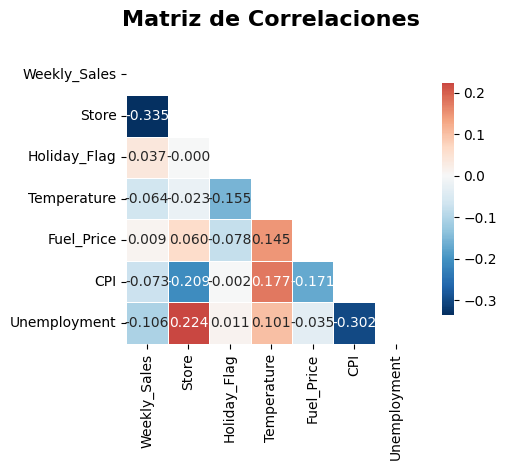


 Correlación de cada variable con Weekly_Sales
Holiday_Flag        : +0.0369
Fuel_Price          : +0.0095
Temperature         : -0.0638
CPI                 : -0.0726
Unemployment        : -0.1062
Store               : -0.3353


In [26]:
#Matiz de correlaciones

# Crear correlaciones
correlation_matrix = df_walmart[['Weekly_Sales', 'Store', 'Holiday_Flag', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment']].corr()

# Crear el heatmap
plt.Figure(figsize=(10, 8))
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

sns.heatmap(correlation_matrix,
            annot=True,
            fmt='.3F',
            cmap='RdBu_r',
            center=0,
            mask=mask,
            square=True,
            linewidths=0.5,
            cbar_kws={'shrink':0.8})

plt.title('Matriz de Correlaciones', fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.savefig('04_matriz_correlaciones.png', dpi=150, bbox_inches='tight')
plt.show()

# Correlaciones con la variable objetivo
print("\n Correlación de cada variable con Weekly_Sales")
print("="*50)
correlaciones = correlation_matrix['Weekly_Sales'].sort_values(ascending=False)
for var, corr in correlaciones.items():
    if var != 'Weekly_Sales':
        print(f"{var:20}: {corr:+.4f}")

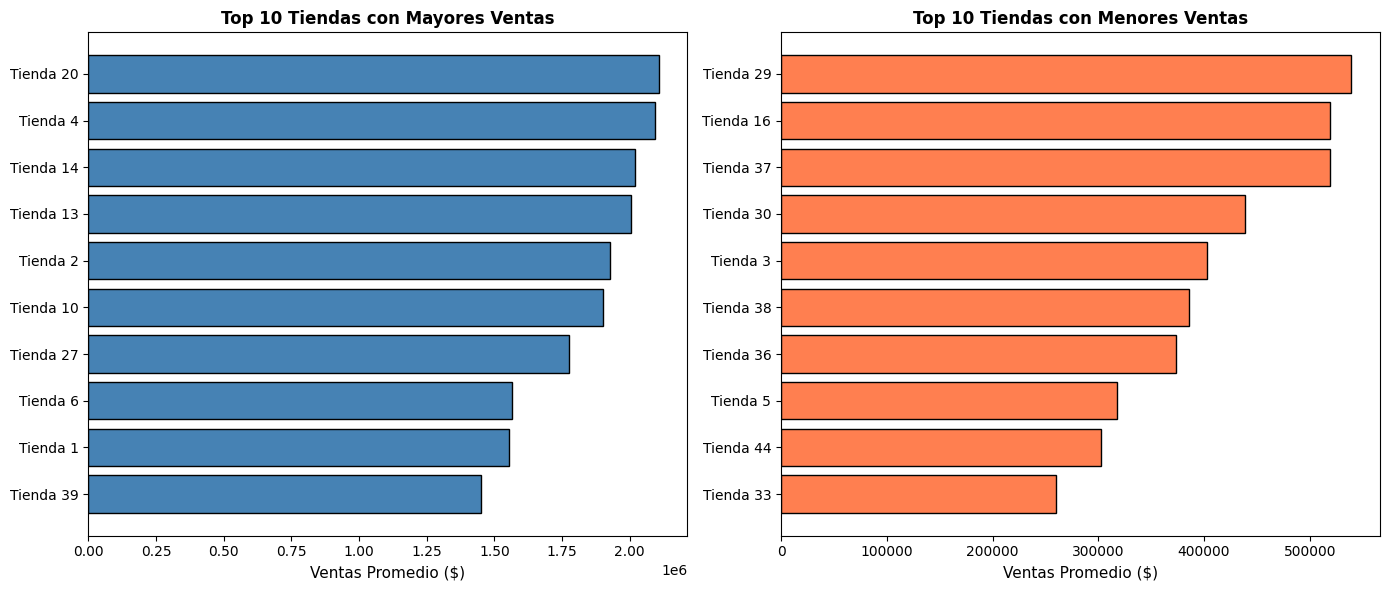

In [27]:
# Análisis de ventas por tienda

ventas_por_tienda = df_walmart.groupby('Store')['Weekly_Sales'].agg(['mean', 'std', 'sum']).round(2)
ventas_por_tienda.columns = ['Promedio', 'Desv_Std', 'Total']
ventas_por_tienda = ventas_por_tienda.sort_values('Promedio', ascending=False)

# Top 10 tiendas con mayores ventas promedio
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
top10 = ventas_por_tienda.head(10)
bars = plt.barh(range(10), top10['Promedio'].values, color='steelblue', edgecolor='black')
plt.yticks(range(10), [f'Tienda {i}' for i in top10.index])
plt.xlabel('Ventas Promedio ($)', fontsize=11)
plt.title('Top 10 Tiendas con Mayores Ventas', fontsize=12, fontweight='bold')
plt.gca().invert_yaxis()

# Bottom 10 tiendas
plt.subplot(1, 2, 2)
bottom10 = ventas_por_tienda.tail(10)
bars = plt.barh(range(10), bottom10['Promedio'].values, color='coral', edgecolor='black')
plt.yticks(range(10), [f'Tienda {i}' for i in bottom10.index])
plt.xlabel('Ventas Promedio ($)', fontsize=11)
plt.title('Top 10 Tiendas con Menores Ventas', fontsize=12, fontweight='bold')
plt.gca().invert_yaxis()

plt.tight_layout()
plt.savefig('05_ventas_por_tienda.png', dpi=150, bbox_inches='tight')
plt.show()

<Figure size 1800x600 with 0 Axes>

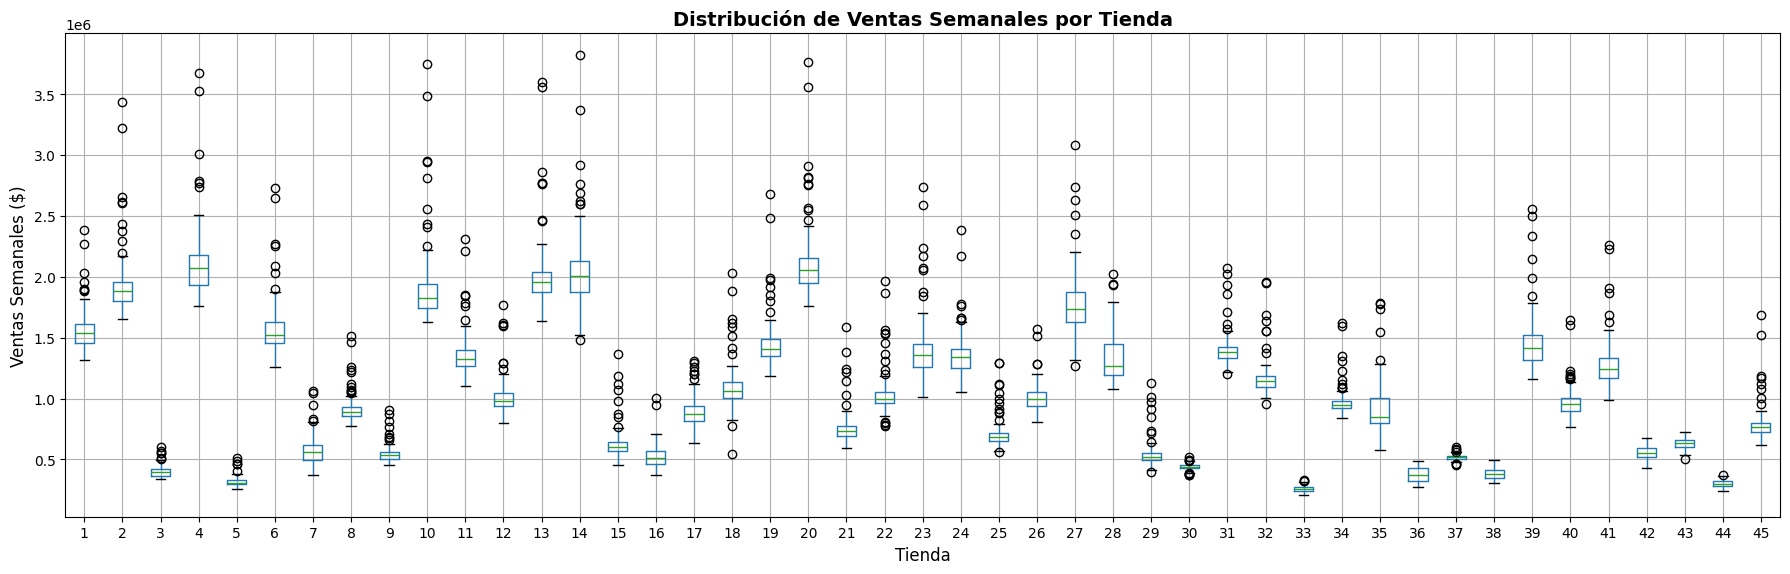

In [28]:
# Boxplot de ventas por tienda

plt.figure(figsize=(18, 6))
df_walmart.boxplot(column='Weekly_Sales', by='Store', figsize=(18, 6))
plt.title('Distribución de Ventas Semanales por Tienda', fontsize=14, fontweight='bold')
plt.suptitle('')  # Eliminar el título automático
plt.xlabel('Tienda', fontsize=12)
plt.ylabel('Ventas Semanales ($)', fontsize=12)
plt.xticks(rotation=0)
plt.tight_layout()
plt.savefig('06_boxplot_ventas_tienda.png', dpi=150, bbox_inches='tight')
plt.show()

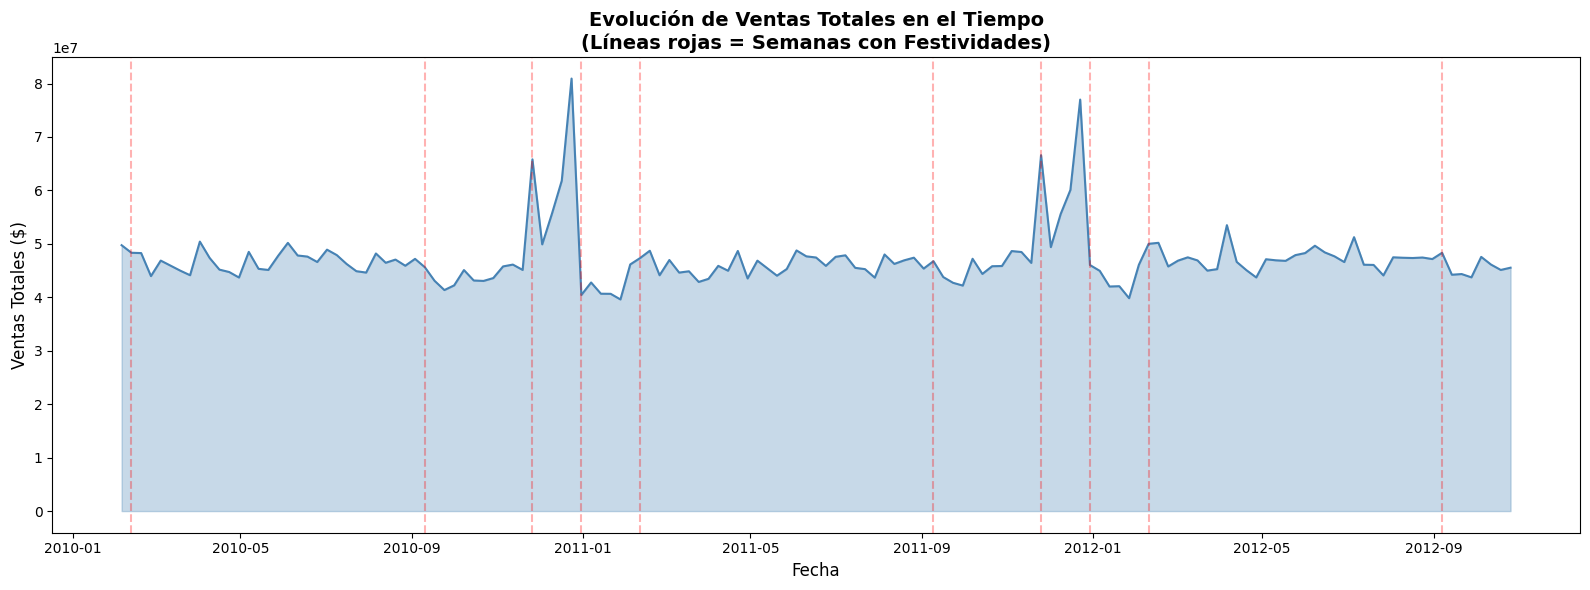

In [29]:
# Análisis temporal de ventas

# Agrupar ventas por fecha
ventas_tiempo = df_walmart.groupby('Date')['Weekly_Sales'].sum().reset_index()

plt.figure(figsize=(16, 6))
plt.plot(ventas_tiempo['Date'], ventas_tiempo['Weekly_Sales'], color='steelblue', linewidth=1.5)
plt.fill_between(ventas_tiempo['Date'], ventas_tiempo['Weekly_Sales'], alpha=0.3, color='steelblue')

# Marcar días festivos
holidays = df_walmart[df_walmart['Holiday_Flag'] == 1]['Date'].unique()
for holiday in holidays:
    plt.axvline(x=holiday, color='red', linestyle='--', alpha=0.3)

plt.xlabel('Fecha', fontsize=12)
plt.ylabel('Ventas Totales ($)', fontsize=12)
plt.title('Evolución de Ventas Totales en el Tiempo\n(Líneas rojas = Semanas con Festividades)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('07_ventas_tiempo.png', dpi=150, bbox_inches='tight')
plt.show()

C:\Users\rrosm\AppData\Local\Temp\ipykernel_21088\849946224.py:21: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = axes[1].boxplot([df_no_holiday, df_holiday], labels=['No Festivo', 'Festivo'], patch_artist=True)
C:\Users\rrosm\AppData\Local\Temp\ipykernel_21088\849946224.py:27: UserWarning: Glyph 128230 (\N{PACKAGE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\rrosm\AppData\Local\Temp\ipykernel_21088\849946224.py:28: UserWarning: Glyph 128230 (\N{PACKAGE}) missing from font(s) DejaVu Sans.
  plt.savefig('08_impacto_festividades.png', dpi=150, bbox_inches='tight')
c:\Users\rrosm\Documents\GitHub\walmart\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128230 (\N{PACKAGE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


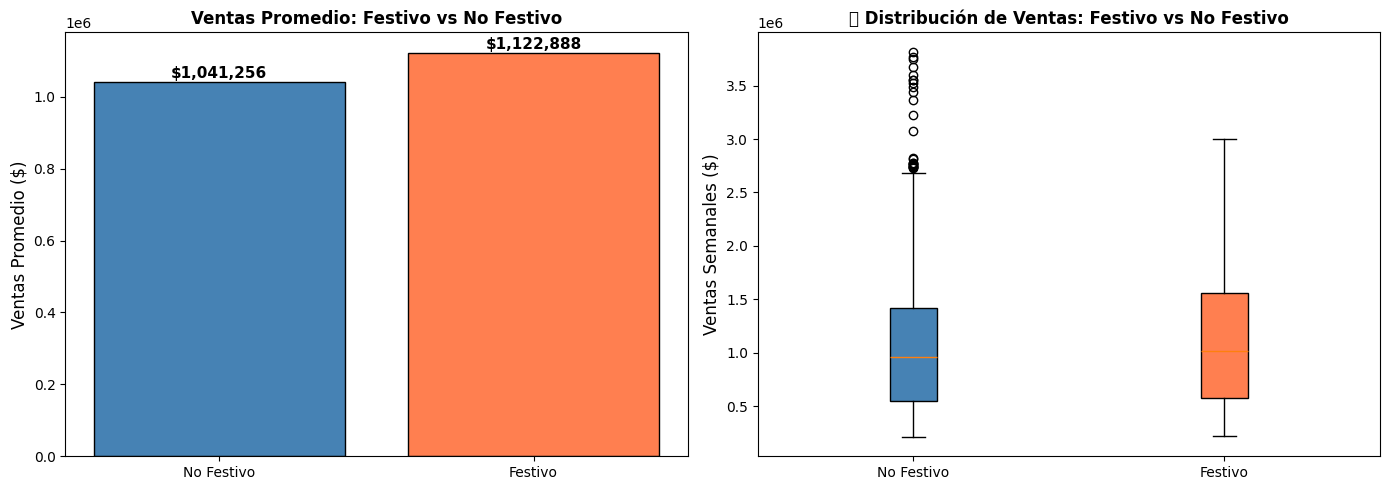


 Comparación estadística:
Ventas promedio - No Festivo: $1,041,256.38
Ventas promedio - Festivo: $1,122,887.89
Diferencia: $81,631.51
Incremento porcentual: 7.84%


In [30]:
# Ventas en días festivos vs. no festivos

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Gráfico de barras
ventas_holiday = df_walmart.groupby('Holiday_Flag')['Weekly_Sales'].mean()
colors_bar = ['steelblue', 'coral']
bars = axes[0].bar(['No Festivo', 'Festivo'], ventas_holiday.values, color=colors_bar, edgecolor='black')
axes[0].set_ylabel('Ventas Promedio ($)', fontsize=12)
axes[0].set_title('Ventas Promedio: Festivo vs No Festivo', fontsize=12, fontweight='bold')

# Añadir valores sobre las barras
for bar, val in zip(bars, ventas_holiday.values):
    axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 10000, 
                f'${val:,.0f}', ha='center', fontsize=11, fontweight='bold')

# Boxplot comparativo
df_holiday = df_walmart[df_walmart['Holiday_Flag'] == 1]['Weekly_Sales']
df_no_holiday = df_walmart[df_walmart['Holiday_Flag'] == 0]['Weekly_Sales']

bp = axes[1].boxplot([df_no_holiday, df_holiday], labels=['No Festivo', 'Festivo'], patch_artist=True)
bp['boxes'][0].set_facecolor('steelblue')
bp['boxes'][1].set_facecolor('coral')
axes[1].set_ylabel('Ventas Semanales ($)', fontsize=12)
axes[1].set_title('📦 Distribución de Ventas: Festivo vs No Festivo', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.savefig('08_impacto_festividades.png', dpi=150, bbox_inches='tight')
plt.show()

# Estadísticas
print("\n Comparación estadística:")
print("="*50)
print(f"Ventas promedio - No Festivo: ${df_no_holiday.mean():,.2f}")
print(f"Ventas promedio - Festivo: ${df_holiday.mean():,.2f}")
print(f"Diferencia: ${df_holiday.mean() - df_no_holiday.mean():,.2f}")
print(f"Incremento porcentual: {((df_holiday.mean() / df_no_holiday.mean()) - 1) * 100:.2f}%")

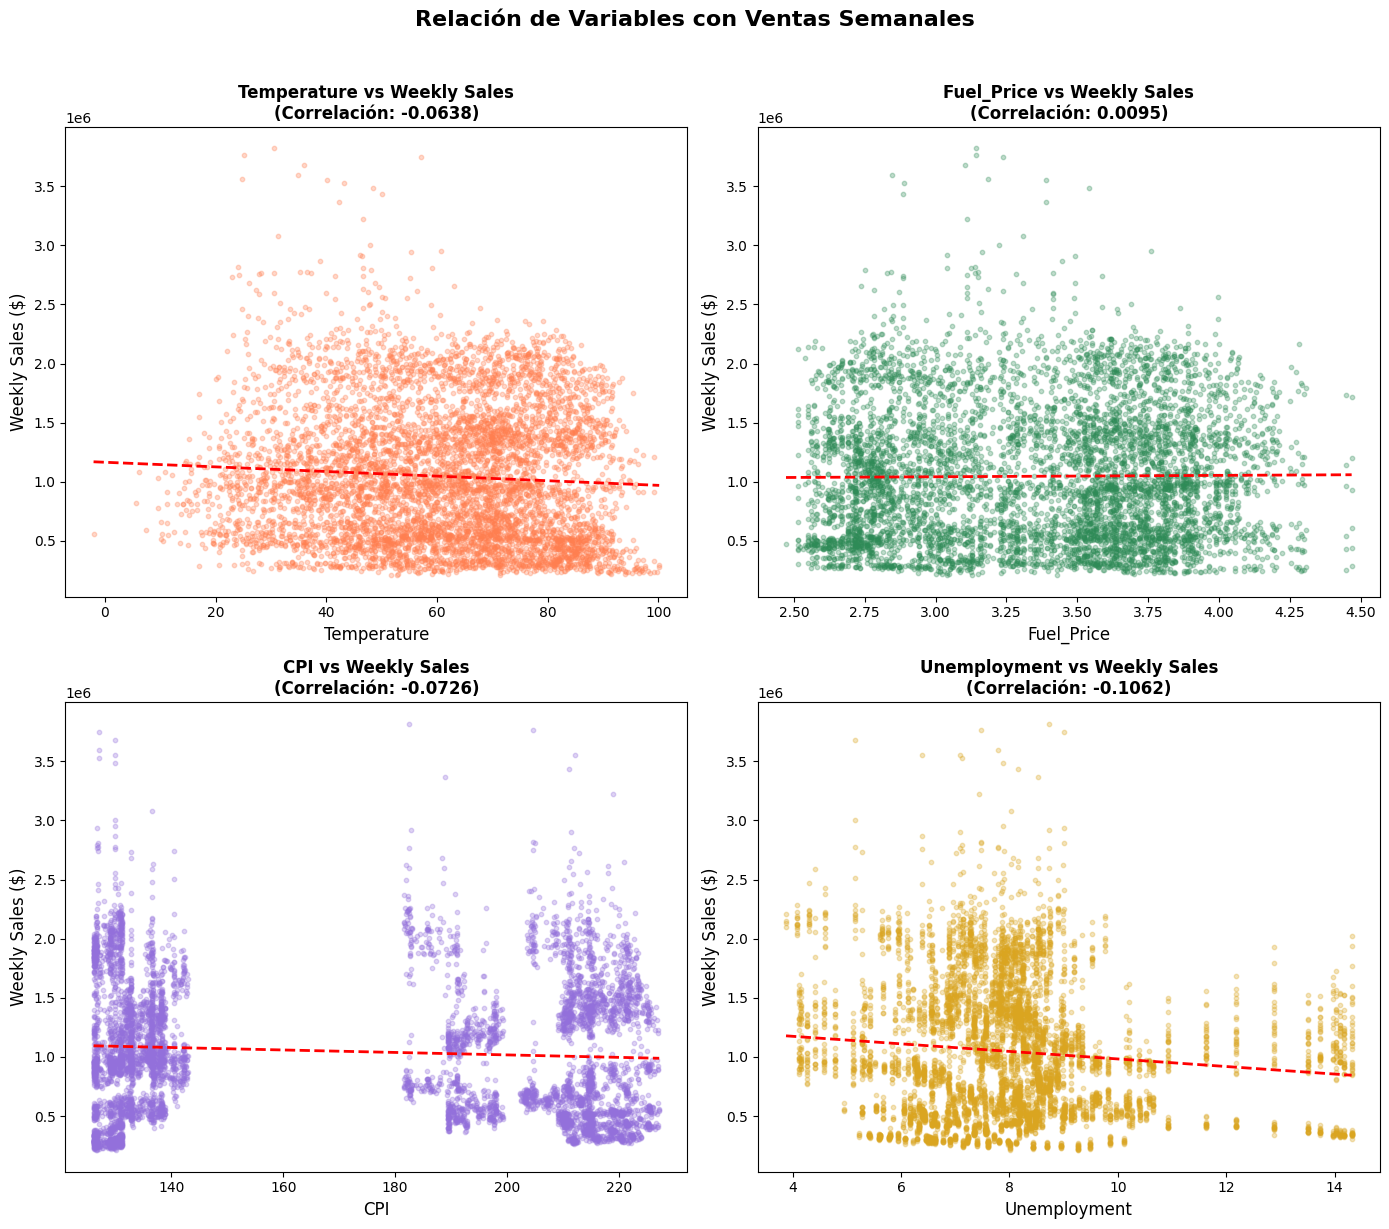

In [31]:
# Análisis de relación entre variables

## Scatter plots - Relación con Weekly_Sales

fig, axes = plt.subplots(2, 2, figsize=(14, 12))

variables = ['Temperature', 'Fuel_Price', 'CPI', 'Unemployment']
colors_scatter = ['coral', 'seagreen', 'mediumpurple', 'goldenrod']

for i, (var, color) in enumerate(zip(variables, colors_scatter)):
    ax = axes[i//2, i%2]
    ax.scatter(df_walmart[var], df_walmart['Weekly_Sales'], alpha=0.3, c=color, s=10)
    
    # Línea de tendencia
    z = np.polyfit(df_walmart[var], df_walmart['Weekly_Sales'], 1)
    p = np.poly1d(z)
    ax.plot(sorted(df_walmart[var]), p(sorted(df_walmart[var])), color='red', linewidth=2, linestyle='--')
    
    corr = df_walmart[var].corr(df_walmart['Weekly_Sales'])
    ax.set_xlabel(var, fontsize=12)
    ax.set_ylabel('Weekly Sales ($)', fontsize=12)
    ax.set_title(f'{var} vs Weekly Sales\n(Correlación: {corr:.4f})', fontsize=12, fontweight='bold')

plt.suptitle('Relación de Variables con Ventas Semanales', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('09_scatter_plots.png', dpi=150, bbox_inches='tight')
plt.show()

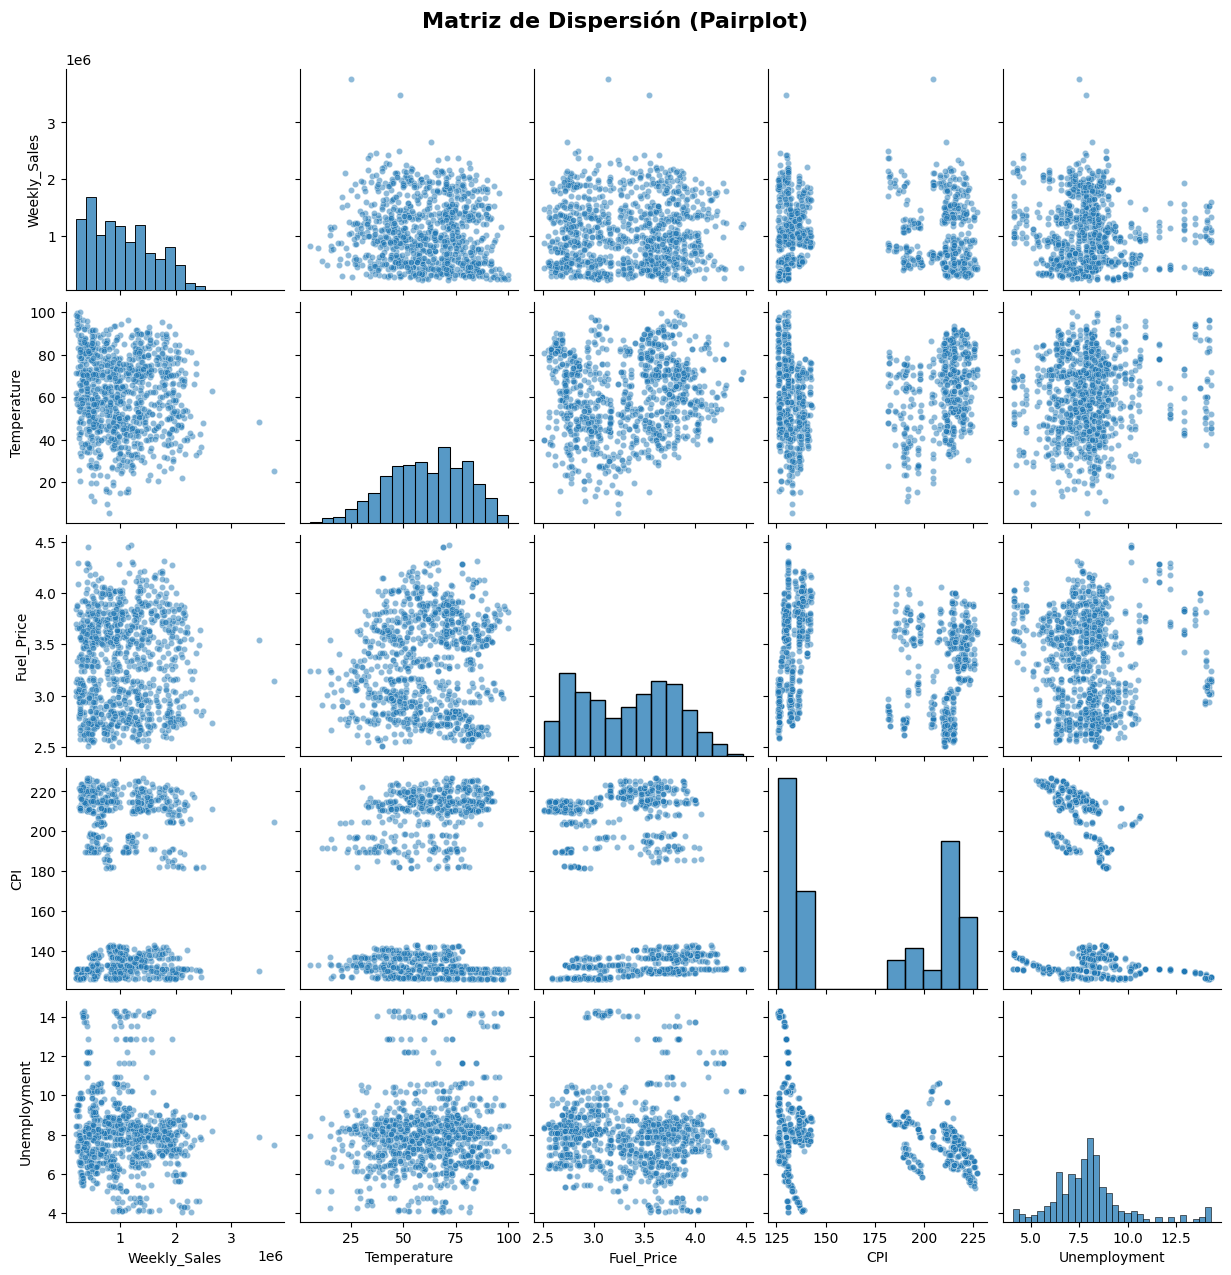

In [32]:
# Pairplot (Matríz de dispersión)

# Tomar una muestra (más rápido)
df_sample = df_walmart.sample(n=1000, random_state=42)

sns.pairplot(df_sample[['Weekly_Sales', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment']], 
             diag_kind='hist',
             plot_kws={'alpha': 0.5, 's': 20},
             height=2.5)

plt.suptitle('Matriz de Dispersión (Pairplot)', fontsize=16, fontweight='bold', y=1.02)
plt.savefig('10_pairplot.png', dpi=150, bbox_inches='tight')
plt.show()